In [13]:
#import libraries 

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import re 
import matplotlib.pyplot as plt 
import seaborn as sns

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer 
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.cross_validation import train_test_split, cross_val_score, cross_val_predict
from sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV

from sklearn import naive_bayes
from sklearn import svm, grid_search
from sklearn.linear_model import LogisticRegression

from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, precision_recall_curve, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, classification_report

from nltk.stem.porter import PorterStemmer
from textblob import TextBlob
from sklearn.decomposition import PCA

import imblearn
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler
from sklearn.pipeline import Pipeline

from tqdm import tqdm_notebook as tqdm
pd.set_option('display.max_rows',20000)


from nltk import FreqDist
import pandas_profiling

/home/devvrat/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/home/devvrat/anaconda3/lib/python3.6/site-packages/pandas_profiling/plot.py:15: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/devvrat/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/devvrat/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/devvrat/anaconda3/lib/python3.6/site-packages/ipyker

In [2]:
#loading the data set 
df1 = pd.read_json('reviews_Cell_Phones_and_Accessories_5.json', lines=True)

#creating data frame with needed columns
df1_new = df1[['asin','reviewText','overall']].copy()

#creating the new data frame such that the Score ! = 3
#we are considering the score values as - 
# 4 or 5 = 1 positive polarity
# 1 or 2 = 0 negative polarity
#score of 3 = Neutral 
#since the scope of the problem statement is binary classifier for reviews so there is no need for the 
#neutral reviews hence removing score which have value = 3
df = df1_new[df1_new.overall != 3]

#adding column for number of words in review in original data frame
df['#words'] = df.reviewText.apply(lambda x: len(str(x).split(' ')))

/home/devvrat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [3]:
#Functions for preprocessing steps
stpwrds = set(('a', 'about', 'above', 'across', 'after', 'afterwards', 'again', 'against', 'all', 'almost', 'alone', 'along', 'already', 'also','although','always','am','among', 'amongst', 'amoungst', 'amount',  'an', 'and', 'another', 'any','anyhow','anyone','anything','anyway', 'anywhere', 'are', 'around', 'as',  'at', 'back','be','became', 'because','become','becomes', 'becoming', 'been', 'just', 'before', 'beforehand', 'behind', 'being', 'below', 'beside', 'besides', 'between', 'beyond', 'bill', 'both', 'bottom','but', 'by', 'call', 'can', 'co', 'con', 'could',  'cry', 'did', 'de', 'describe', 'detail', 'do', 'doing', 'does', 'done', 'down', 'due', 'during', 'each', 'eg', 'either', 'else', 'elsewhere', 'empty', 'enough', 'etc', 'even', 'ever', 'every', 'everyone', 'everything', 'everywhere', 'except', 'few', 'fify', 'fill', 'find', 'fire', 'first', 'for', 'former', 'formerly', 'found', 'from', 'front', 'full', 'further', 'get', 'give', 'go', 'had', 'has',  'have', 'he', 'hence', 'her', 'here', 'hereafter', 'hereby', 'herein', 'hereupon', 'hers', 'herself', 'him', 'himself', 'his', 'how', 'however', 'i', 'ie', 'if', 'in', 'inc', 'indeed', 'interest', 'into', 'is', 'it', 'its', 'itself', 'keep', 'last', 'latter', 'latterly', 'least', 'less', 'ltd', 'made', 'many', 'may', 'me', 'meanwhile', 'might', 'mill', 'mine', 'more', 'moreover', 'most', 'mostly', 'move', 'much', 'must', 'my', 'myself', 'name', 'namely', 'neither', 'nevertheless', 'next', 'nine', 'nobody', 'none', 'noone', 'nor', 'nothing', 'now', 'nowhere', 'of', 'off', 'often', 'on', 'once', 'only', 'onto', 'or', 'other', 'others', 'otherwise', 'our', 'ours', 'ourselves', 'out', 'over', 'own','part', 'per', 'perhaps', 'please', 'put', 'rather', 're', 'same', 'see', 'seem', 'seemed', 'seeming', 'seems', 'serious', 'several', 'she', 'should', 'show', 'side', 'since', 'sincere',  'so', 'some', 'somehow', 'someone', 'something', 'sometime', 'sometimes', 'somewhere', 'still', 'such', 'system', 'take', 'than', 'that', 'the', 'their', 'them', 'themselves', 'then', 'thence', 'there', 'thereafter', 'thereby', 'therefore', 'therein', 'thereupon', 'these', 'they', 'thickv', 'thin', 'this', 'those', 'though', 'through', 'throughout', 'thru', 'thus', 'to', 'together', 'too', 'top', 'toward', 'towards', 'twelve', 'twenty', 'two', 'un', 'under', 'until', 'up', 'upon', 'us', 'very', 'via', 'was', 'we', 'well', 'were', 'what', 'whatever', 'when', 'whence', 'whenever', 'where', 'whereafter', 'whereas', 'whereby', 'wherein', 'whereupon', 'wherever', 'whether', 'which', 'while', 'whither', 'who', 'whoever', 'whole', 'whom', 'whose', 'why', 'will', 'with', 'within', 'without', 'would', 'yet', 'you', 'your', 'yours', 'yourself', 'yourselves', 'the'))
sno = nltk.stem.SnowballStemmer('english')

def replace_url(df,col,rm1,rm2):
    return(df[col].str.replace(rm1,rm2,regex=True))

def extract_emo(df, col, emo):
    return(df[col].str.extractall(emo).unstack().apply(lambda x:' '.join(x.dropna()), axis=1))

def replace_emo(df,col,emo1,emo2):
    return(df[col].str.replace(emo1,emo2))

def replace_punct(df, col, punct1, punct2):
    return(df[col].str.replace(punct1, punct2))

def remove_alphnum(df,col):
    return(df[col].apply(lambda i: " ".join(i for i in i.split() if i.isalpha())))

def remove_stop(df,col):
    return(df[col].apply(lambda x: " ".join(x for x in x.split() if x.lower() not in stpwrds)))

def stemming(df,col):
    return(df[col].apply(lambda x: " ".join([sno.stem(word) for word in x.split()])))

#def grammer_correct(df,col):
#    return(df[col].apply(lambda x: str(TextBlob(x).correct())))

def tokenize(df,col):
    return(df.apply(lambda row: nltk.word_tokenize(row[col]), axis=1))

def join_word(df,col,word1,word2):
    return(df[col].str.replace(word1,word2))


In [4]:
df['nohtml'] = replace_url(df,'reviewText','^http?:\/\/.*[\r\n]*','')
df['emoticons']=extract_emo(df,'nohtml','(=\)|:\)|:-\)|:\(|:-\(|;\)|;-\)|:D|=D|:-D|=\(|:P|=P|:-P)')
df['nohtml'] = replace_emo(df,'nohtml','(=\)|:\)|:-\)|:D|=D|:-D)','happy')
df['nohtml'] = replace_emo(df,'nohtml','(=\(|:\(|:-\()','sad')
df['nohtml'] = replace_emo(df,'nohtml','(;\)|;-\))','wink')
df['nohtml'] = replace_emo(df,'nohtml','(:P|=P|:-P)','playful')
df['nohtml'] = replace_punct(df, 'nohtml', '[^!\w\s]','')
#df['nohtml'] = remove_alphnum(df,'nohtml')
df['nohtml'] = remove_stop(df,'nohtml')
df['nohtml'] = stemming(df,'nohtml')
#df['nohtml'] = grammer_correct(df,'nohtml')
df['tokenized'] = tokenize(df,'nohtml')
#df['nohtml'] = join_word(df,'nohtml',r'\b(no|not|dont|doesnt|cant|cannot|wouldnt|wont|couldnt|hasnt|havent|shouldnt)\s+([a-z])',r'\1_\2')


/home/devvrat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/devvrat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/devvrat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

In [5]:
#changing the overall data into 1 or 0 
def partition(x):
    '''This is the function which gives the overall more than 3 as 1 and less than 3 as 0 '''
    if x < 3:
        return (0)
    return (1) 

actualScore = df['overall']
postiveNegative = actualScore.map(partition)
df['overall'] = postiveNegative

/home/devvrat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [6]:
df['nohtml'][0]

'look good stick good! dont like round shape bump siri kept pop irrit wont buy product like'

In [7]:
df['#nohtml'] = df.nohtml.apply(lambda x: len(str(x).split(' ')))

/home/devvrat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


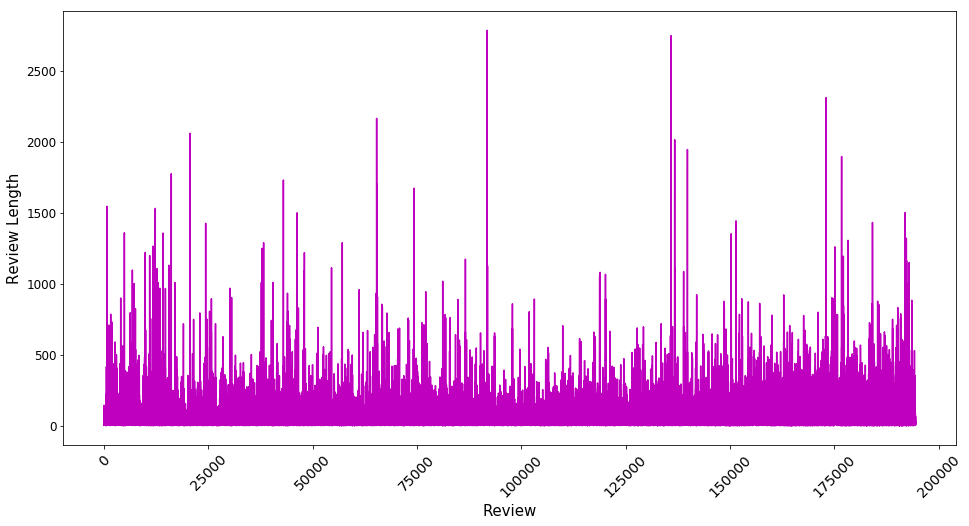

In [9]:
plt.xlabel('Review',fontsize=15)
plt.ylabel('Review Length',fontsize=15)
plt.yticks(fontsize=12)
plt.xticks(fontsize=14, rotation=45)
plt.rcParams['figure.figsize'] = (16,8)
plt.plot(df['#nohtml'],color='m')

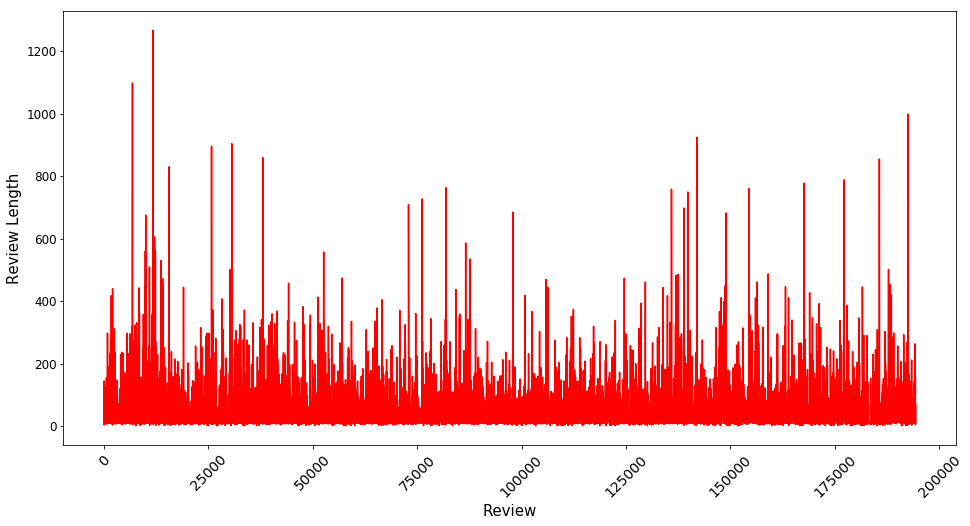

In [10]:
class0 = df[df['overall']==0]
plt.xlabel('Review',fontsize=15)
plt.ylabel('Review Length',fontsize=15)
plt.yticks(fontsize=12)
plt.xticks(fontsize=14, rotation=45)
plt.rcParams['figure.figsize'] = (16,8)
plt.plot(class0['#nohtml'],color='r')

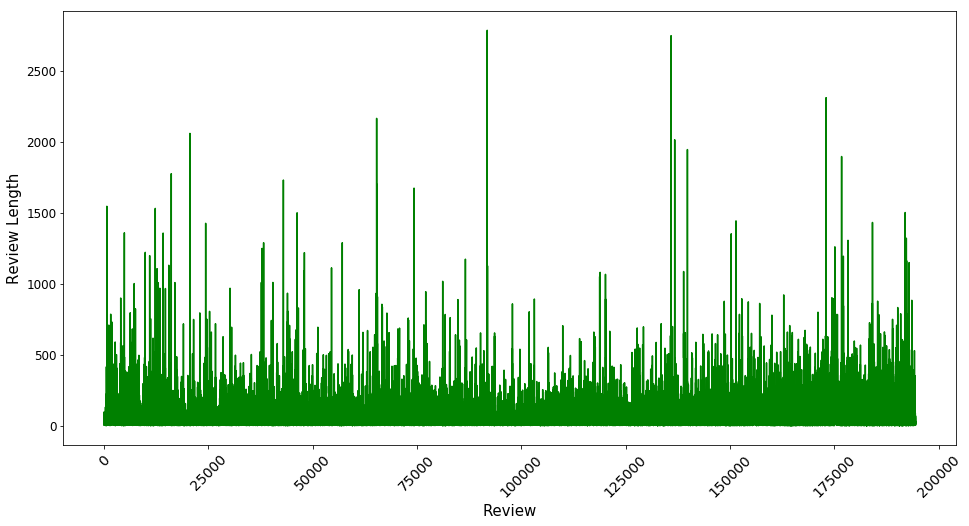

In [11]:
class1 = df[df['overall']==1]
plt.xlabel('Review',fontsize=15)
plt.ylabel('Review Length',fontsize=15)
plt.yticks(fontsize=12)
plt.xticks(fontsize=14, rotation=45)
plt.rcParams['figure.figsize'] = (16,8)
plt.plot(class1['#nohtml'],color='g')

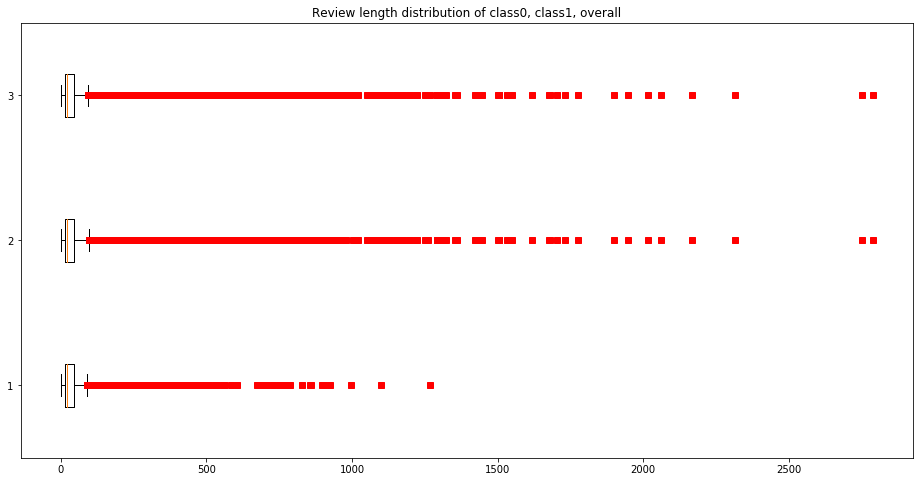

In [84]:
#Review length distribution using box plot
data = [class0['#nohtml'], class1['#nohtml'], df['#nohtml']]
fig7, ax7 = plt.subplots()
ax7.set_title('Review length distribution of class0, class1, overall')
plt
plt.boxplot(data, 0, 'rs', 0)
plt.show()

<BarContainer object of 14 artists>

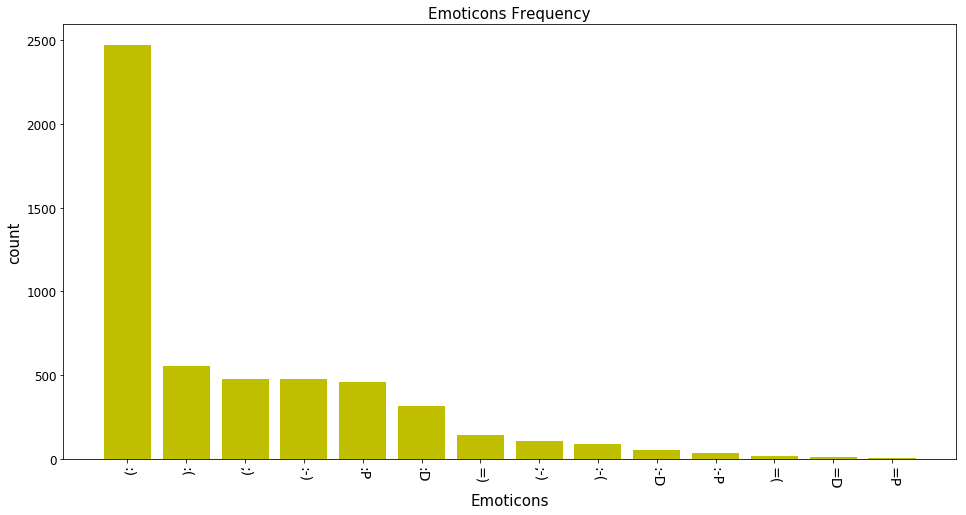

In [13]:
#Emoticons
df_emonan = df[['emoticons']].copy()
#removing nan
df_emonan['emoticons'].replace('', np.nan, inplace=True)
df_emonan.dropna(subset=['emoticons'], inplace=True)

b = pd.Series(' '.join(df_emonan.emoticons).split()).value_counts()[:]
names = b.index
values = b.values
plt.xlabel('Emoticons',fontsize=15)
plt.ylabel('count',fontsize=15)
plt.title('Emoticons Frequency',fontsize=15)
plt.yticks(fontsize=12)
plt.xticks(fontsize=14, rotation=270)
plt.rcParams['figure.figsize'] = (16,8)
plt.bar(names,values,color='y')

In [14]:
b

:)     2470
:(      555
;)      478
:-)     477
:P      459
:D      320
=)      145
;-)     110
:-(      93
:-D      56
:-P      37
=(       20
=D       10
=P        9
dtype: int64

<BarContainer object of 25 artists>

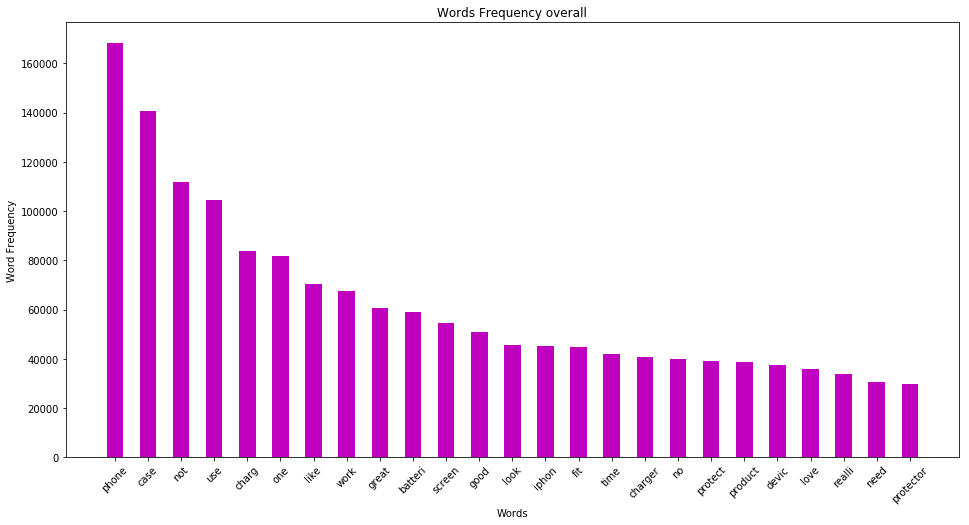

In [15]:
#clean words recurring in whole dataset
a1 = pd.Series(' '.join(df.nohtml).split()).value_counts()[:]
names01 = a1.index[0:25]
values01 = a1.values[0:25]
plt.xlabel('Words')
plt.ylabel('Word Frequency')
plt.title('Words Frequency overall')
plt.xticks(fontsize=10, rotation=45)
plt.rcParams['figure.figsize'] = (16,8)
plt.bar(names01,values01, width=0.5, color='m')

<BarContainer object of 25 artists>

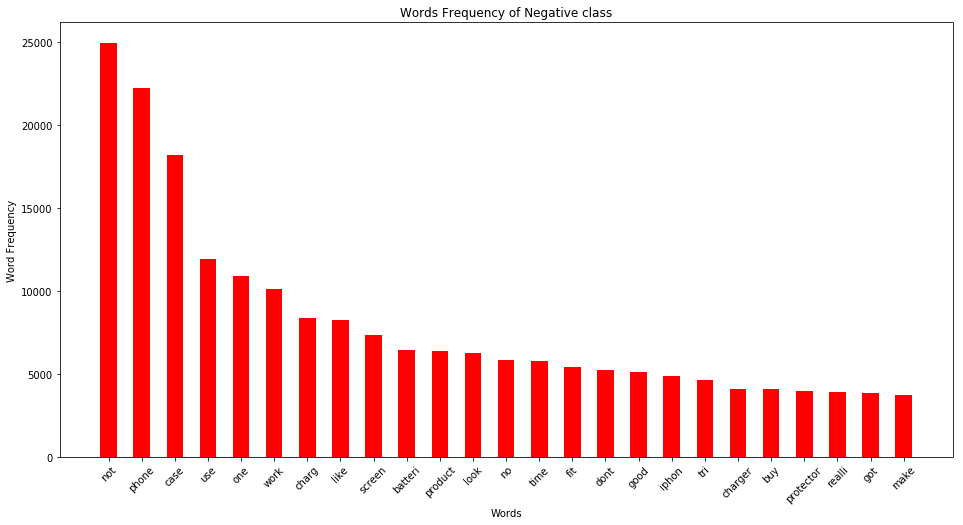

In [16]:
#class0 clean words recurring
class0 = df[df['overall']==0]
b1 = pd.Series(' '.join(class0.nohtml).split()).value_counts()[:]
names0 = b1.index[0:25]
values0 = b1.values[0:25]
plt.xlabel('Words')
plt.ylabel('Word Frequency')
plt.title('Words Frequency of Negative class')
plt.xticks(fontsize=10, rotation=45)
plt.rcParams['figure.figsize'] = (16,8)
plt.bar(names0,values0,width=0.5,color='r')

<BarContainer object of 25 artists>

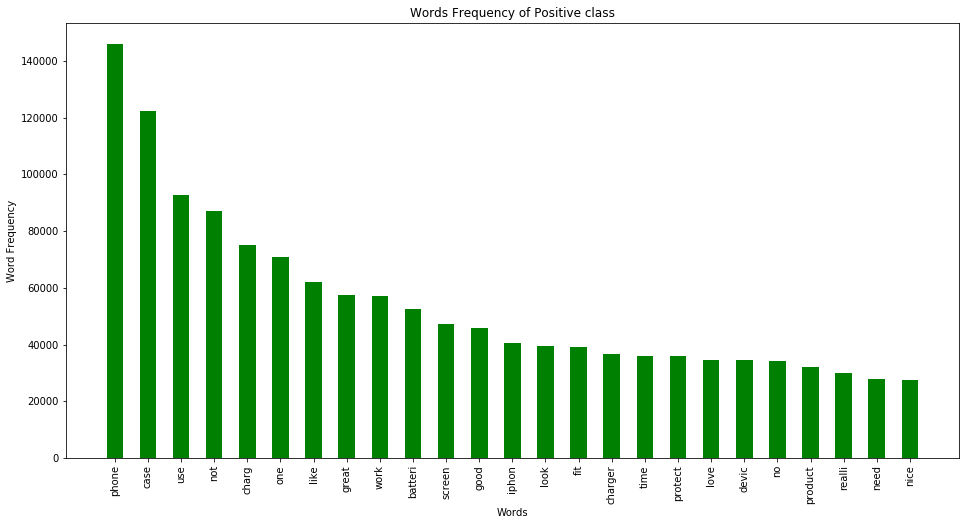

In [17]:
#class1 clean words recurring
class1 = df[df['overall']==1]
c1 = pd.Series(' '.join(class1.nohtml).split()).value_counts()[:]
names1 = c1.index[0:25]
values1 = c1.values[0:25]
plt.xlabel('Words')
plt.ylabel('Word Frequency')
plt.title('Words Frequency of Positive class')
plt.xticks(fontsize=10, rotation=90)
plt.rcParams['figure.figsize'] = (16,8)
plt.bar(names1,values1,width=0.5,color='g')

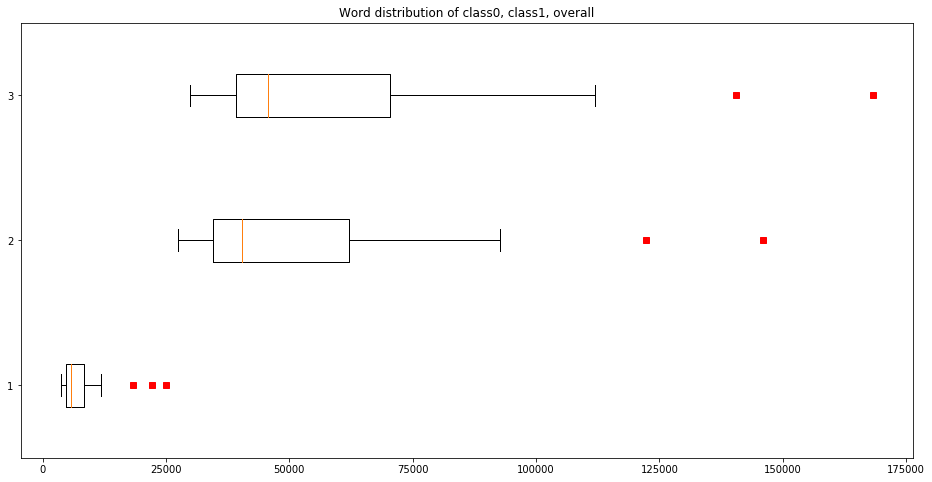

In [103]:
#Words frequency distribution using box plot
data = [values0, values1, values01]
fig7, ax7 = plt.subplots()
ax7.set_title('Word distribution of class0, class1, overall')
plt
plt.boxplot(data, 0, 'rs', 0)
plt.show()

In [8]:
df['nohtml'][0]

'look good stick good! dont like round shape bump siri kept pop irrit wont buy product like'

In [9]:
df.head(100)

,asin,reviewText,overall,#words,nohtml,emoticons,tokenized,#nohtml
0,120401325X,They look good and stick good! I just don't li...,1,37,look good stick good! dont like round shape bu...,NaN,"[look, good, stick, good, !, dont, like, round...",17
1,120401325X,These stickers work like the review says they ...,1,32,sticker work like review say stick great stay ...,:),"[sticker, work, like, review, say, stick, grea...",14
2,120401325X,These are awesome and make my phone look so st...,1,34,awesom make phone look stylish! use one far ye...,NaN,"[awesom, make, phone, look, stylish, !, use, o...",15
3,120401325X,Item arrived in great time and was in perfect ...,1,51,item arriv great time perfect condit order but...,NaN,"[item, arriv, great, time, perfect, condit, or...",25
4,120401325X,"awesome! stays on, and looks great. can be use...",1,24,awesome! stay look great use multipl appl prod...,NaN,"[awesome, !, stay, look, great, use, multipl, ...",14
6,120401325X,Came just as described.. It doesn't come unstu...,1,23,came describ doesnt come unstuck cute! peopl a...,NaN,"[came, describ, doesnt, come, unstuck, cute, !...",11
7,3998899561,it worked for the first week then it only char...,0,20,work week charg phone 20 wast money,NaN,"[work, week, charg, phone, 20, wast, money]",7
8,3998899561,"Good case, solid build. Protects phone all aro...",1,44,good case solid build protect phone good acces...,NaN,"[good, case, solid, build, protect, phone, goo...",26
9,3998899561,This is a fantastic case. Very stylish and pro...,1,35,fantast case stylish protect phone easi access...,NaN,"[fantast, case, stylish, protect, phone, easi,...",18
10,3998899561,this case fits perfectly on the s4 and keeps m...,1,21,case fit perfect s4 keep powerd day cant compl...,NaN,"[case, fit, perfect, s4, keep, powerd, day, ca...",10


In [23]:
###################################################TF-IDF##############################################################

In [10]:
#TF-IDF on tokenized clean review
def dummy_fun(doc):
    return doc

tfidf = TfidfVectorizer(
    analyzer='word',
    tokenizer=dummy_fun,
    preprocessor=dummy_fun,
    token_pattern=None)  


#get the list of top tf-idf features with the values 
def top_tfidf_feat(row,features,top_n):
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i],row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature','tfidf']
    return df 


tfidf_token = tfidf.fit_transform(df['tokenized'].values)

#knowing what are the actual features represented by the tf-idf word representation 
features = tfidf.get_feature_names()
top_tfidf = top_tfidf_feat(tfidf_token[0,:].toarray()[0],features,5000)
print(top_tfidf)

                                                feature     tfidf
0                                                  siri  0.366926
1                                                 irrit  0.365059
2                                                 round  0.307517
3                                                  bump  0.300456
4                                                 shape  0.284034
5                                                  kept  0.272687
6                                                   pop  0.271511
7                                                  good  0.252036
8                                                 stick  0.238764
9                                                  like  0.228172
10                                                 wont  0.213483
11                                                  buy  0.160910
12                                                 dont  0.151241
13                                              product  0.139866
14        

# ML 3

## ML SMOTE CV

In [11]:
#SMOTE
X = tfidf_token
y = df.overall
smote = SMOTE(ratio='minority', random_state=2)
X_sm, y_sm = smote.fit_sample(X, y)

## Naive Bayes

In [14]:
#ML
X_sm_train, X_sm_test, y_sm_train, y_sm_test = train_test_split(X_sm, y_sm, test_size=0.20, random_state=42)

nb = naive_bayes.MultinomialNB()
nb.fit(X_sm_train, y_sm_train)
y_sm_nb_class = nb.predict(X_sm_test)

#Cross validation 10 fold
score = cross_val_score(nb, X_sm, y_sm, cv=10)
predict = cross_val_predict(nb, X_sm, y_sm, cv=10)

#svm = svm.SVC().fit(X_sm_train, y_sm_train)
#y_sm_svm_class = svm.predict(X_sm_test)

## Logistic Regression

In [20]:
# Create logistic regression
logistic = LogisticRegression()

# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = np.logspace(0, 4, 10)

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)

# Create grid search using 10-fold cross validation
clf = GridSearchCV(logistic, hyperparameters, cv=10, verbose=0)

# Fit grid search
best_model = clf.fit(X_sm, y_sm)

# View best hyperparameters
print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])

# Predict target vector
best_model.predict(X_sm)

Best Penalty: l1
Best C: 59.94842503189409


array([0, 1, 1, ..., 0, 0, 0])

In [22]:
lr_predict = best_model.predict(X_sm)
lr_predict

array([0, 1, 1, ..., 0, 0, 0])

# Evaluation

In [24]:
#Evaluation
print('\n NB Comparison')
print ("True", y_sm_test[0:50])
print ("Pred", y_sm_nb_class[0:50])
print('\n NB Comparison CV')
print ("True", y_sm[0:50])
print ("Pred", predict[0:50])
print('\n LR Comparison CV')
print ("True", y_sm[0:50])
print ("Pred", lr_predict[0:50])


 NB Comparison
True [1 1 0 0 1 1 0 0 0 0 1 0 0 1 1 1 0 1 1 1 1 0 0 0 1 1 0 0 1 1 1 0 1 1 0 0 1
 1 1 0 0 0 1 1 1 0 0 1 1 0]
Pred [1 1 0 1 1 1 1 1 0 1 1 0 0 1 1 1 0 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 0 0 1
 1 0 0 0 0 1 1 1 1 1 1 1 0]

 NB Comparison CV
True [1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 0 1 1 1 0 1 1 0 1 1 1
 1 0 1 1 1 0 1 0 1 1 1 1 1]
Pred [1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 1 1 1 0 1 1 0 1 1 1
 1 1 1 1 1 0 1 0 1 1 1 1 1]

 LR Comparison CV
True [1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 0 1 1 1 0 1 1 0 1 1 1
 1 0 1 1 1 0 1 0 1 1 1 1 1]
Pred [0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 0 1 1 1 0 1 1 0 1 1 1
 1 0 1 1 1 0 1 0 1 1 1 1 1]


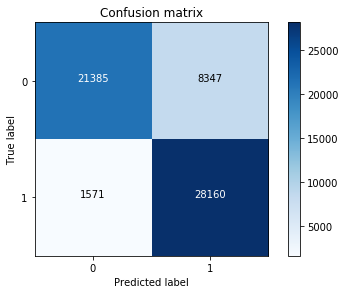

Classification accuracy     :  0.8332072044800969
Classification error        :  0.16679279551990311
Specificity                 :  0.7192587111529665
False Positive rate         :  0.2807412888470335
Recall or True positive rate:  [0.71925871 0.94715953]
Precision                   :  [0.93156473 0.77135892]
F1 score                    :  [0.81175979 0.85026722]




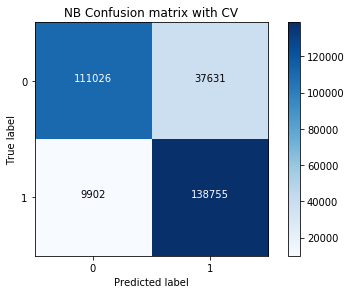

Classification accuracy     :  0.8401252547811405
Classification error        :  0.15987474521885947
Specificity                 :  0.7468602218529904
False Positive rate         :  0.25313977814700955
Recall or True positive rate:  [0.74686022 0.93339029]
Precision                   :  [0.91811657 0.7866554 ]
F1 score                    :  [0.82368084 0.85376396]


--------ROC Curve---------
ROC AUC score:  0.942779317907655


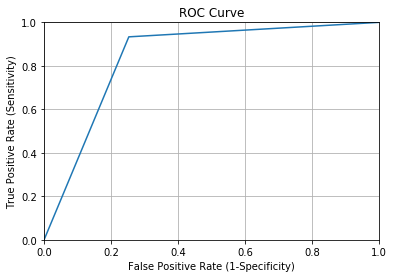

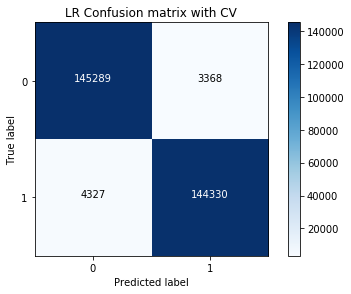

Classification accuracy     :  0.9741182722643401
Classification error        :  0.025881727735659887
Specificity                 :  0.9773438183200253
False Positive rate         :  0.022656181679974706
Recall or True positive rate:  [0.97734382 0.97089273]
Precision                   :  [0.9710793  0.97719671]
F1 score                    :  [0.97420149 0.97403452]


--------ROC Curve---------


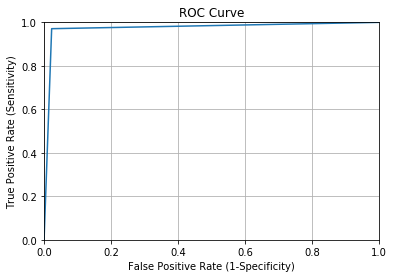

In [36]:
#Confusion metrics

import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


##############################################################
confusion = metrics.confusion_matrix(y_sm_test, y_sm_nb_class)
TP = confusion[1,1]
TN = confusion[0,0]
FP = confusion[0,1]
FN = confusion[1,0]


class_names = [0,1]
plt.figure()
plot_confusion_matrix(confusion , classes=class_names, title='Confusion matrix')
plt.show()


#Classification accuracy
#print("Classification accuracy: ",(TP+TN)/(TP+TN+FP+FN))
print("Classification accuracy     : ",metrics.accuracy_score(y_sm_test, y_sm_nb_class))

#Classification error or misclassification rate
#print("Classification error: ",(FP+FN)/(TP+TN+FP+FN))
print("Classification error        : ",1-metrics.accuracy_score(y_sm_test, y_sm_nb_class))

#Specificity: Actual value negative, how often prediction correct?
print("Specificity                 : ",(TN)/(TN+FP))

#False Positive rate: Actual value negative, how often prediction incorrect?
print("False Positive rate         : ",(FP)/(TN+FP))

#Sensitivity or Recall or True positive rate: Actual value positive, how often prediction correct?
#print("Recall or True positive rate: ",(TP)/(TP+FN))
print("Recall or True positive rate: ",metrics.recall_score(y_sm_test, y_sm_nb_class, average=None))

#Precision: Predicted value is positive, how often prediction correct?
#print("Precision: ",(TP)/(TP+FP))
print("Precision                   : ",metrics.precision_score(y_sm_test, y_sm_nb_class, average=None))

#F1 Score:
print("F1 score                    : ",f1_score(y_sm_test, y_sm_nb_class, average=None))


#############################################################
print('\n')
confusion_cv = metrics.confusion_matrix(y_sm, predict)
TP1 = confusion_cv[1,1]
TN1 = confusion_cv[0,0]
FP1 = confusion_cv[0,1]
FN1 = confusion_cv[1,0]


class_names = [0,1]
plt.figure()
plot_confusion_matrix(confusion_cv , classes=class_names, title='NB Confusion matrix with CV')
plt.show()


#Classification accuracy
#print("Classification accuracy: ",(TP1+TN1)/(TP1+TN1+FP1+FN1))
print("Classification accuracy     : ",metrics.accuracy_score(y_sm, predict))

#Classification error or misclassification rate
#print("Classification error: ", (FP1+FN1)/(TP1+TN1+FP1+FN1))
print("Classification error        : ",1-metrics.accuracy_score(y_sm, predict))

#Specificity: Actual value negative, how often prediction correct?
print("Specificity                 : ",(TN1)/(TN1+FP1))

#False Positive rate: Actual value negative, how often prediction incorrect?
print("False Positive rate         : ",(FP1)/(TN1+FP1))

#Sensitivity or Recall or True positive rate: Actual value positive, how often prediction correct?
#print("Recall or True positive rate: ",(TP1)/(TP1+FN1))
print("Recall or True positive rate: ",metrics.recall_score(y_sm, predict, average=None))

#Precision: Predicted value is positive, how often prediction correct?
#print("Precision: ",(TP1)/(TP1+FP1))
print("Precision                   : ",metrics.precision_score(y_sm, predict, average=None))

#F1 Score:
print("F1 score                    : ",f1_score(y_sm, predict, average=None))

print('\n')
##############################
#ROC Curve
print('--------ROC Curve---------')
#Prediction probability classwise
class1_prob = nb.predict_proba(X_sm)[:,1:2]
class0_prob = nb.predict_proba(X_sm)[:,0:1]

fpr, tpr, thresholds = metrics.roc_curve(y_sm, predict)
plt.plot(fpr,tpr)
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.title('ROC Curve')
plt.xlabel('False Positive Rate (1-Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

#ROC Area under the curve
#print("Area under the curve class 1: ", roc_auc_score(y_sm, class1_prob))
#print("Area under the curve class 0: ", roc_auc_score(y_sm, class0_prob))
score1 = cross_val_score(nb, X_sm, y_sm, cv=10, scoring='roc_auc').mean()
print("ROC AUC score: ",score1)






###############################################################
lr_confusion_cv = metrics.confusion_matrix(y_sm, lr_predict)
lr_TP1 = lr_confusion_cv[1,1]
lr_TN1 = lr_confusion_cv[0,0]
lr_FP1 = lr_confusion_cv[0,1]
lr_FN1 = lr_confusion_cv[1,0]


class_names = [0,1]
plt.figure()
plot_confusion_matrix(lr_confusion_cv , classes=class_names, title='LR Confusion matrix with CV')
plt.show()


#Classification accuracy
#print("Classification accuracy: ",(lr_TP1+lr_TN1)/(lr_TP1+lr_TN1+lr_FP1+lr_FN1))
print("Classification accuracy     : ",metrics.accuracy_score(y_sm, lr_predict))

#Classification error or misclassification rate
#print("Classification error: ", (lr_FP1+lr_FN1)/(lr_TP1+lr_TN1+lr_FP1+lr_FN1))
print("Classification error        : ",1-metrics.accuracy_score(y_sm, lr_predict))

#Specificity: Actual value negative, how often prediction correct?
print("Specificity                 : ",(lr_TN1)/(lr_TN1+lr_FP1))

#False Positive rate: Actual value negative, how often prediction incorrect?
print("False Positive rate         : ",(lr_FP1)/(lr_TN1+lr_FP1))

#Sensitivity or Recall or True positive rate: Actual value positive, how often prediction correct?
#print("Recall or True positive rate: ",(lr_TP1)/(lr_TP1+lr_FN1))
print("Recall or True positive rate: ",metrics.recall_score(y_sm, lr_predict, average=None))

#Precision: Predicted value is positive, how often prediction correct?
#print("Precision: ",(lr_TP1)/(lr_TP1+lr_FP1))
print("Precision                   : ",metrics.precision_score(y_sm, lr_predict, average=None))

#F1 Score:
print("F1 score                    : ",f1_score(y_sm, lr_predict, average=None))

print('\n')
###############################################################
#ROC Curve
print('--------ROC Curve---------')
#Prediction probability classwise
lr_class1_prob = nb.predict_proba(X_sm)[:,1:2]
lr_class0_prob = nb.predict_proba(X_sm)[:,0:1]

lr_fpr, lr_tpr, lr_thresholds = metrics.roc_curve(y_sm, lr_predict)
plt.plot(lr_fpr,lr_tpr)
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.title('ROC Curve')
plt.xlabel('False Positive Rate (1-Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)



In [ ]:
#ROC Area under the curve
#print("Area under the curve class 1: ", roc_auc_score(y_sm, class1_prob))
#print("Area under the curve class 0: ", roc_auc_score(y_sm, class0_prob))
lr_score1 = cross_val_score(clf, X_sm, y_sm, cv=10, scoring='roc_auc').mean()
print("ROC AUC score: ",lr_score1)

In [120]:
#Creating variable for ML input, Naive Bayes, Accuracy
y=df.overall
X=tfidf_token
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
clf = naive_bayes.MultinomialNB()
clf.fit(X_train, y_train)
y_pred_class = clf.predict(X_test)

In [122]:
#Calculate accuracy with oversampling
metrics.accuracy_score(y_test, y_pred_class)

0.8584104046242774

In [ ]:
roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])

In [128]:
max(y_test.mean(), 1-y_test.mean())

0.8583815028901735

In [140]:
print ("True", y_test.values[0:40])
print ("Pred", y_pred_class[0:40])

True [1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1]
Pred [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1]


1    148657
0    148657
Name: overall, dtype: int64


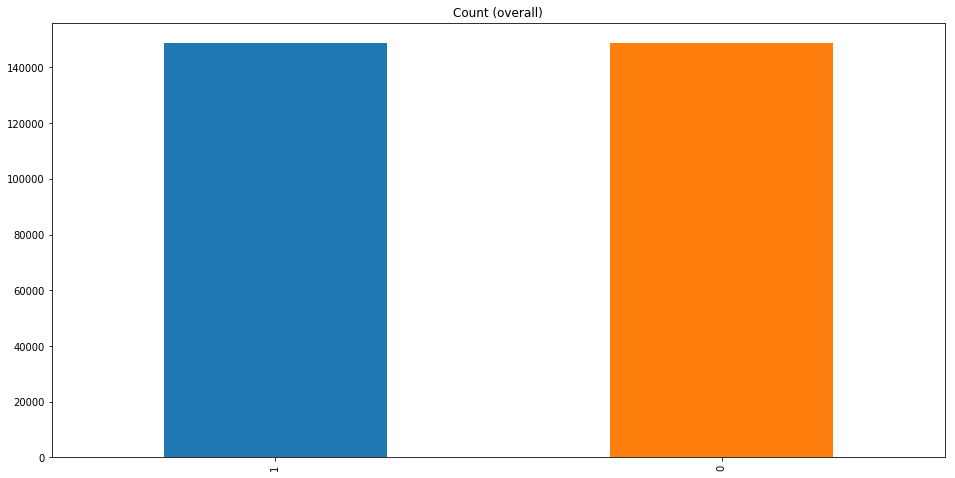

In [24]:
#Over Sampling
# Class count
count_class_1, count_class_0 = df.overall.value_counts()

# Divide by class
df_class_0 = df[df['overall'] == 0]
df_class_1 = df[df['overall'] == 1]

#Random over-sampling:
df_class_0_over = df_class_0.sample(count_class_1, replace=True)
df_test_over = pd.concat([df_class_1, df_class_0_over], axis=0)

print(df_test_over.overall.value_counts())

df_test_over.overall.value_counts().plot(kind='bar', title='Count (overall)');

In [85]:
df_test_over = df_test_over[['asin','nohtml','overall','#nohtml','tokenized']].copy()
df_test_over.head(5)

,asin,nohtml,overall,#nohtml,tokenized
0,120401325X,look good stick good! dont like round shape bu...,1,17,"[look, good, stick, good, !, dont, like, round..."
1,120401325X,sticker work like review say stick great stay ...,1,14,"[sticker, work, like, review, say, stick, grea..."
2,120401325X,awesom make phone look stylish! use one far ye...,1,15,"[awesom, make, phone, look, stylish, !, use, o..."
3,120401325X,item arriv great time perfect condit order but...,1,25,"[item, arriv, great, time, perfect, condit, or..."
4,120401325X,awesome! stay look great use multipl appl prod...,1,14,"[awesome, !, stay, look, great, use, multipl, ..."


In [77]:
#TF-IDF on tokenized clean review after oversampling
def dummy_fun(doc):
    return doc

over_tfidf = TfidfVectorizer(
    analyzer='word',
    tokenizer=dummy_fun,
    preprocessor=dummy_fun,
    token_pattern=None,
    ngram_range=(1,2))  

over_tfidf_token = over_tfidf.fit_transform(df_test_over['tokenized'])
print(over_tfidf_token)

  (0, 1103721)	0.058203660232363924
  (0, 810439)	0.11603725678745876
  (0, 1793068)	0.1024557401400026
  (0, 0)	0.056072626568895965
  (0, 592128)	0.06388167081904063
  (0, 1073019)	0.1032351191991048
  (0, 1605059)	0.13794482638736832
  (0, 1674469)	0.12799370533176851
  (0, 312176)	0.13251266008149656
  (0, 1704651)	0.16682451205002835
  (0, 1019791)	0.11540850242747758
  (0, 1427183)	0.11753274359031417
  (0, 988084)	0.1574362925014124
  (0, 2087503)	0.09147741362205489
  (0, 320439)	0.06826925281248787
  (0, 1471522)	0.060832432129427745
  (0, 1105386)	0.11577247138854446
  (0, 814176)	0.23500578792185484
  (0, 1793525)	0.21607526600342525
  (0, 810440)	0.16368801382845724
  (0, 1310)	0.14758978243844922
  (0, 593299)	0.1211319082548986
  (0, 1078536)	0.22529576247819066
  (0, 1605399)	0.23734016733344845
  (0, 1674564)	0.2860221217065537
  :	:
  (297313, 2057205)	0.08672791710816112
  (297313, 2102565)	0.13733179774206306
  (297313, 411365)	0.10963600668725122
  (297313, 1509204)

In [35]:
#knowing what are the actual features represented by the tf-idf word representation after oversampling
over_features = over_tfidf.get_feature_names()

#get the list of top tf-idf features with the values 

def over_top_tfidf_feat(row,over_features,top_n):
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(over_features[i],row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature','tfidf']
    return df 


over_top_tfidf1 = over_top_tfidf_feat(over_tfidf_token[0,:].toarray()[0],over_features,5000)
print(over_top_tfidf1)

                                                feature     tfidf
0                                            shape bump  0.286022
1                                             siri kept  0.286022
2                                            irrit wont  0.286022
3                                             pop irrit  0.286022
4                                             bump siri  0.286022
5                                           round shape  0.237340
6                                            good stick  0.235006
7                                            like round  0.225296
8                                            stick good  0.216075
9                                              kept pop  0.198266
10                                                 siri  0.166825
11                                             wont buy  0.164317
12                                               good !  0.163688
13                                                irrit  0.157436
14        

In [165]:
#Over sampling and Creating variable for ML input, Naive Bayes, Accuracy
y_over=df_test_over.overall
X_over=over_tfidf_token
X_train_over, X_test_over, y_train_over, y_test_over = train_test_split(X_over, y_over, test_size=0.20, random_state=42)
clf_over = naive_bayes.MultinomialNB()
clf_over.fit(X_train_over, y_train_over)
y_pred_class_over = clf_over.predict(X_test_over)

In [166]:
#Calculate accuracy after oversampling
metrics.accuracy_score(y_test_over, y_pred_class_over)

0.9505406723508737

In [105]:
roc_auc_score(y_test_over, clf_over.predict_proba(X_test_over)[:,1])

0.9933675409743128

In [125]:
y_test_over.value_counts()

0    29904
1    29559
Name: overall, dtype: int64

In [127]:
max(y_test_over.mean(), 1-y_test_over.mean())

0.5029009636244387

In [80]:
df_test_over.describe()['overall']

count    297314.000000
mean          0.500000
std           0.500001
min           0.000000
25%           0.000000
50%           0.500000
75%           1.000000
max           1.000000
Name: overall, dtype: float64

In [81]:
# just to make sure that all Nan containing rows are deleted..
print("No of Nan values in our dataframe : ", sum(df_test_over.isnull().any()))

No of Nan values in our dataframe :  0


In [142]:
print ("True", y_test_over.values[0:50])
print ("Pred", y_pred_class_over[0:50])

True [0 1 0 0 0 1 0 0 0 0 1 1 0 0 0 1 0 1 1 1 1 0 0 0 1 1 0 0 1 1 0 0 1 1 1 0 1
 1 1 0 0 0 1 1 1 0 0 1 1 0]
Pred [0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 1 0 1 1 1 1 0 0 0 1 1 0 0 1 0 0 0 1 1 1 0 1
 0 1 0 0 0 0 1 1 0 0 1 1 0]


In [148]:
#Confusion metrics
confusion = metrics.confusion_matrix(y_test_over, y_pred_class_over)
TP = confusion[1,1]
TN = confusion[0,0]
FP = confusion[0,1]
FN = confusion[1,0]
print (confusion)

[[29385   519]
 [ 2422 27137]]


In [158]:
#Classification accuracy
print("Classification accuracy: ",(TP+TN)/(TP+TN+FP+FN))
print("Classification accuracy: ",metrics.accuracy_score(y_test_over, y_pred_class_over))

#Classification error or misclassification rate
print("Classification error: ", (FP+FN)/(TP+TN+FP+FN))
print("Classification error: ",1-metrics.accuracy_score(y_test_over, y_pred_class_over))

#Sensitivity or Recall or True positive rate: Actual value positive, how often prediction correct?
print("Recall or True positive rate: ",(TP)/(TP+FN))
print("Recall or True positive rate: ",metrics.recall_score(y_test_over, y_pred_class_over))

#Specificity: Actual value negative, how often prediction correct?
print("Specificity: ",(TN)/(TN+FP))

#False Positive rate: Actual value negative, how often prediction incorrect?
print("False Positive rate: ",(FP)/(TN+FP))

#Precision: Predicted value is positive, how often prediction correct?
print("Precision: ",(TP)/(TP+FP))

Classification accuracy:  0.9505406723508737
Classification accuracy:  0.9505406723508737
Classification error:  0.04945932764912635
Classification error:  0.049459327649126306
Recall or True positive rate:  0.9180621807232991
Recall or True positive rate:  0.9180621807232991
Specificity:  0.9826444622792937
False Positive rate:  0.01735553772070626
Precision:  0.9812337286664738
